# PA005: High Value Customer Identification (Insiders)

## 0.0 Planejamento da solução (IoT)

### Entrada (input)

1. Problema de negócio:
    - Selecionar os clientes mais valiosos para integrar um programa de fidelização
    
2. Conjunto de dados:
    - Vendas de um e-commerce online, durante o período de 1 ano (11/2015 a 12/2017)
    

### Saída (output)

1. A indicação das pessoas que farão parte do programa de Insiders
    - Lista: client_id | is_insider |
           10323     | yes/1 
           32413     | no/1
             
2. Relatório om as perguntas de negócio:
    - Quem são as pessoas elegíveis para participar do programa de Insiders ?
    - Quantos clientes farão parte do grupo ?
    - Quais as principais características desses clientes ?
    - Qual a porcentagem de contribuição do faturamento, vinda dos Insiders ?
    - Qual a expectativa de faturamento desse grupo para os próximos meses ?
    - Quais as condições para uma pessoa ser elegível ao Insiders ?
    - Quais as condições para uma pessoa ser removida do Insiders ?
    - Qual a garantia que o programa Insiders é melhor que o restante da base ?
    - Quais ações o time de marketing pode realizar para aumentar o faturamento ?

### Tarefas (tasks)

- Quem são as pessoas elegíveis para participar do programa de Insiders ?
    - O que é ser elegível ? O que são clientes de maior "valor" ?
    - Faturamento:
        - Alto Ticket Médio
        - Alto LTV
        - Baixo recência
        - Alto basket size
        - Baixa probabilidade de churn
        - Alta previsão LTV
        - Alta propensão de compra
        
    - Custo:
        - Baixa taxa de devolução
        
        
    - Experiência de Compra:
        - Média Alta de avaliações
        
        
- Quantos clientes farão parte do grupo ?
    - Número total de clientes
    - % clientes Insiders
    
- Quais as principais características desses clientes ?
    - Escrever características do cliente:
        - Idade
        - Localização
        
    - Escrever características de consumo:
        - Atributos da clusterização
        
        
- Qual a porcentagem de contribuição do faturamento, vinda dos Insiders ?
    - Faturamento total do ano
    - Faturamento do grupo Insiders
    
- Qual a expectativa de faturamento desse grupo para os próximos meses ?
    - LTV do grupo Insiders
    - Análise de Cohort
    
- Quais as condições para uma pessoa ser elegível ao Insiders ?
    - Definir periodicidade (1 mês, 3 meses ...)
    - A pessoa precisa ser similar ou parecida com outra pessoa do grupo
    
- Quais as condições para uma pessoa ser removida do Insiders ?
    - Definir periodicidade (1 mês, 3 meses ...)
    - A pessoa precisa ser dessimilar ou não parecida com outra pessoa do grupo
    
- Qual a garantia que o programa Insiders é melhor que o restante da base ?
    - Teste A/B
    - Teste de hipóteses
    - Teste A/B Bayesiano

- Quais ações o time de marketing pode realizar para aumentar o faturamento ?
     - Desconto
     - Preferencia de compra
     - Frete
     - Visita a empresa

# 0.0 Imports

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score
from plotly import express as px
from sklearn.cluster import KMeans

# 0.1 Helper functions

In [43]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('ggplot')
    plt.rcParams['figure.figsize'] = [24,9]
    plt.rcParams['font.size'] = 15
    
#     display(HTML('<style>.container { width:100% important;}</style>'))
    pd.options.display.max_columns = None
    # pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()
    
jupyter_settings()

pd.set_option('display.float_format', lambda x: '%.2f' % x)
import warnings
warnings.filterwarnings("ignore")

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# 0.2 Load Data

In [44]:
caminho = r'C:\repos\portfolio_projetos\pa005_insider_clustering\data'
df_raw = pd.read_csv(caminho + '\Ecommerce.csv', encoding = 'iso 8859-1')
df_raw = df_raw.drop(['Unnamed: 8'], axis = 1)
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.00,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.00,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.00,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.00,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.00,United Kingdom


# 1.0 Descrição os dados

In [45]:
df1 = df_raw.copy()

## 1.1 Rename columns

In [46]:
cols_new = ['invoice_no','stock_code','description','quantity','invoice_date','unit_price','customer_id','country']

df1.columns = cols_new
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.00,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.00,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.00,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.00,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.00,United Kingdom


## 1.2 Data dimension

In [47]:
print("Number of rows: {} \nNumber of columns: {}".format(df1.shape[0], df1.shape[1]))

Number of rows: 541909 
Number of columns: 8


## 1.3 Data types

In [48]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4 Check NA

In [49]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5 Replace NA

In [50]:
# remove
df1 = df1.dropna(subset = ['description','customer_id'])

print('Removed data: {:.2f}%'.format(100*(1 - (df1.shape[0]/df_raw.shape[0]))))

Removed data: 24.93%


In [51]:
df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

## 1.6 Change dtypes

In [52]:
# invoice_date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

# customer_id
df1['customer_id'] = df1['customer_id'].astype('int64')
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850,United Kingdom


In [53]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int64
country                 object
dtype: object

## 1.7 Descriptive Statistics

# 2.0 Feature Engineering

## 2.1 Feature creation

In [54]:
df_ref = df1.drop(['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'country'], axis = 1).drop_duplicates().reset_index(drop = True)

df_ref.head()

,customer_id
0,17850
1,13047
2,12583
3,13748
4,15100


In [55]:
# gross revenue = quantity * price (faturamento)
df1['gross_revenue'] = df1['quantity'] * df1['unit_price']

# monetary
df_monetary = df1[['customer_id','gross_revenue']].groupby('customer_id').sum().reset_index()

df_ref = pd.merge(df_ref, df_monetary, on = 'customer_id',how = 'left')

# recency - last day purchase
df_recency = df1[['customer_id','invoice_date']].groupby('customer_id').max().reset_index()

# pego o df1 com max() pois eu considero que seria eu olhando pra "hoje" no meu dataset e tirando 'hoje - datas'
df_recency['recency_days'] = (df1['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id','recency_days']].copy()

df_ref = pd.merge(df_ref, df_recency, on = 'customer_id', how = 'left')


# frequency
df_freq = df1[['customer_id','invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_ref = pd.merge(df_ref, df_freq, on = 'customer_id', how = 'left')
df_ref.head()

,customer_id,gross_revenue,recency_days,invoice_no
0,17850,5288.63,302,35
1,13047,3079.10,31,18
2,12583,7187.34,2,18
3,13748,948.25,95,5
4,15100,635.10,330,6


# 3.0 Filtragem das variáveis

# 4.0 Análise Exploratória dos Dados

# 5.0 Data Preparation

# 6.0 Feature Selection

# 7.0 Hyperparameter Fine Tunning

In [56]:
df_ref.head()

,customer_id,gross_revenue,recency_days,invoice_no
0,17850,5288.63,302,35
1,13047,3079.10,31,18
2,12583,7187.34,2,18
3,13748,948.25,95,5
4,15100,635.10,330,6


In [57]:
X = df_ref.drop(['customer_id'], axis = 1)
X.head()

,gross_revenue,recency_days,invoice_no
0,5288.63,302,35
1,3079.10,31,18
2,7187.34,2,18
3,948.25,95,5
4,635.10,330,6


In [58]:
clusters = [2,3,4,5,6]

## 7.1 Within-Cluster Sum of Squares (WSS)

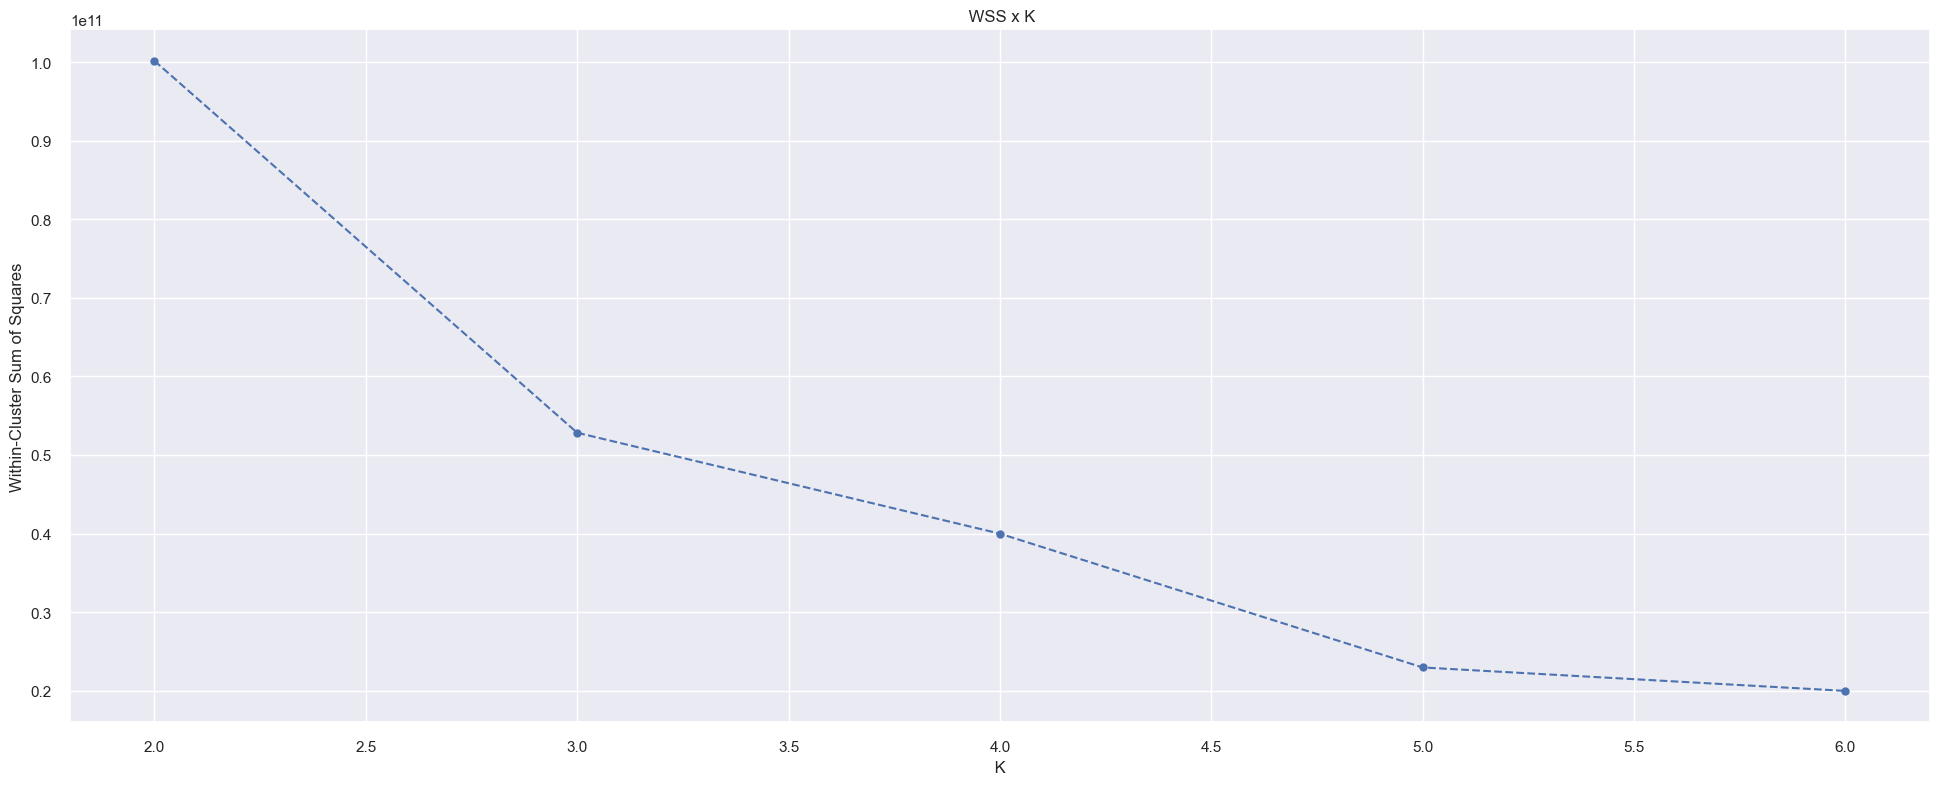

In [59]:
wss = []
for k in clusters:
    # model definition
    kmeans = KMeans(init = 'random', n_clusters= k, n_init = 10, max_iter= 300, random_state= 42)

    # model training
    kmeans.fit(X)

    # validation
    wss.append(kmeans.inertia_)

# plot wss - elbow method
plt.plot( clusters, wss, linestyle = '--', marker = 'o', color = 'b')
plt.xlabel(' K ')
plt.ylabel('Within-Cluster Sum of Squares')
plt.title(' WSS x K');

## 7.2 Silhouette Score

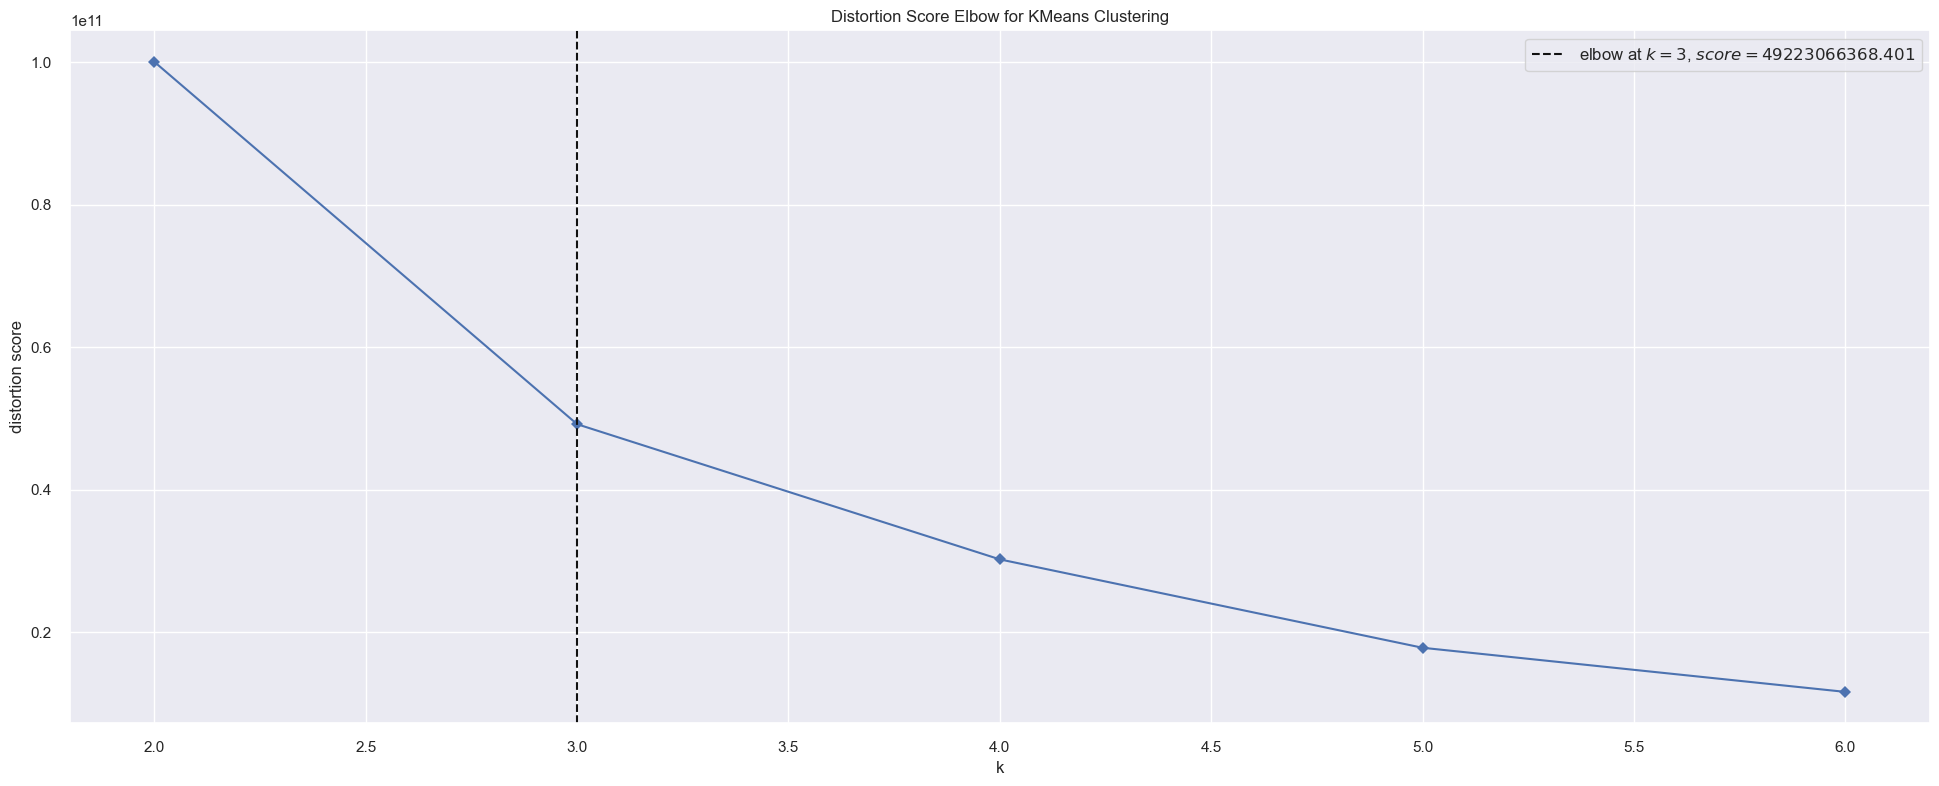

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [60]:
kmeans = KElbowVisualizer(KMeans(), k = clusters, timings=False)
kmeans.fit(X)
kmeans.show()

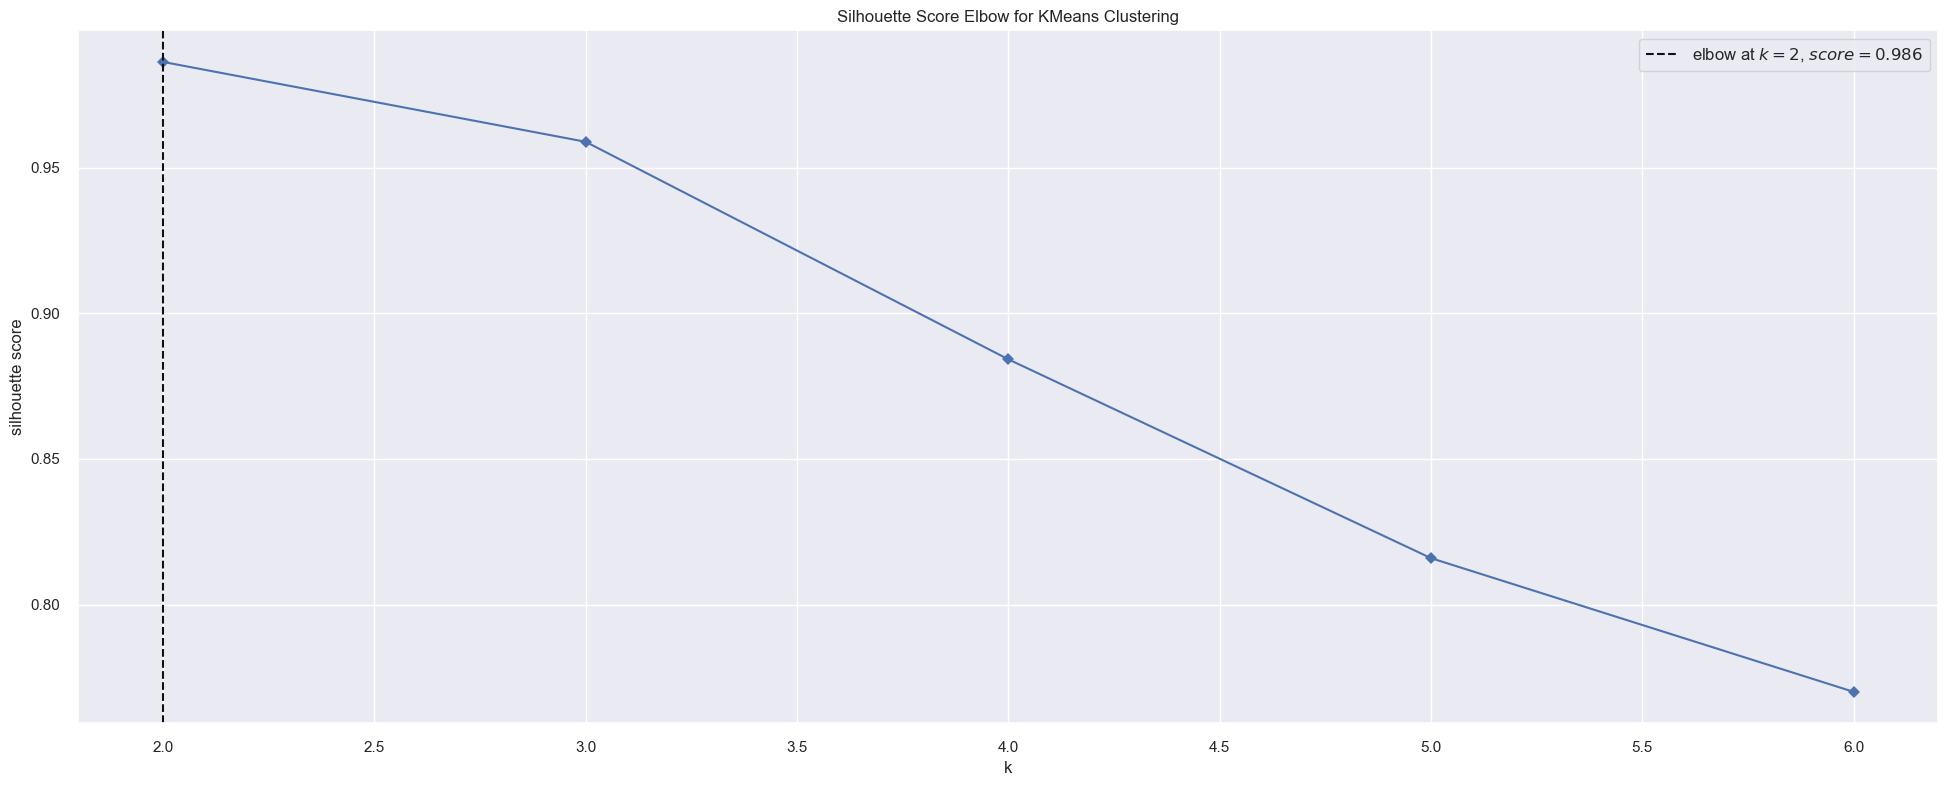

<AxesSubplot: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [61]:
kmeans = KElbowVisualizer(KMeans(), k = clusters, metric= 'silhouette', timings=False)
kmeans.fit(X)
kmeans.show()

# 8.0 Model Training

## 8.1 K-Means

In [62]:
# model definition
k = 3
kmeans = KMeans(init= 'random', n_clusters= k, n_init= 10, max_iter= 300, random_state= 42)

# model training
kmeans.fit(X)

# clustering
labels = kmeans.labels_

## 8.2 Cluster Validation

In [63]:
# WSS
print('WSS score: {}'.format(kmeans.inertia_))

## SS
print('SS score: {}'.format(silhouette_score(X, labels, metric = 'euclidean')))


WSS score: 52830442008.00695
SS score: 0.9494677566681542


# 9.0 Cluster Analysis

In [64]:
df2 = df_ref.copy()
df2['cluster'] = labels

## 9.1  Visualization Inspection

In [65]:
fig = px.scatter_3d(df2, x = 'recency_days', y = 'invoice_no', z = 'gross_revenue', color = 'cluster')
fig.show()

## 9.2 Cluster Profile

In [68]:
# number of customer
df_cluster = df2[['customer_id','cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_cluster'] = 100 * df_cluster['customer_id'] / df_cluster['customer_id'].sum()

# average gross revenue
df_cluster_gross_revenue = df2[['gross_revenue','cluster']].groupby('cluster').mean().reset_index()
df_cluster = df_cluster.merge(df_cluster_gross_revenue, on = 'cluster', how = 'left')

# average recency days
df_cluster_recency_days = df2[['recency_days','cluster']].groupby('cluster').mean().reset_index()
df_cluster = df_cluster.merge(df_cluster_recency_days, on = 'cluster', how = 'left')

# average invoice no
df_cluster_invoice_no = df2[['invoice_no','cluster']].groupby('cluster').mean().reset_index()
df_cluster = df_cluster.merge(df_cluster_invoice_no, on = 'cluster', how = 'left')


df_cluster

,cluster,customer_id,perc_cluster,gross_revenue,recency_days,invoice_no
0,0,4335,99.15,1372.58,92.26,4.61
1,1,6,0.14,182181.98,7.17,89.00
2,2,31,0.71,40543.52,13.29,53.29


- Cluster 01:
    - Número de clientes: 6 (0,14 % do total)
    - Recência média de 7 dias
    - Compras em média de 89 compras
    - Receita média de $ 182.181,98
    

- Cluster 02:
    - Número de clientes: 31 (0,71 % do total)
    - Recência média de 13 dias
    - Compras em média de 53 compras
    - Receita média de $ 40.543,52


- Cluster 03:
    - Número de clientes: 4335 (99,15 % do total)
    - Recência média de 92 dias
    - Compras em média de 4 compras
    - Receita média de $ 1372,58

# 10.0 Deploy to Production